In [ ]:
# !pip install imantics
# !pip install patchify

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.models import load_model
import tensorflow as tf


@tf.keras.utils.register_keras_serializable(package="Custom")
def bulinding_iou(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    # Only keep patches that have some damage
    mask = tf.reduce_sum(y_true, axis=[1,2,3]) > 0
    y_true = tf.boolean_mask(y_true, mask)
    y_pred = tf.boolean_mask(y_pred, mask)

    # If no damage patches exist, return 0
    def compute_iou():
        intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
        union = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3]) - intersection
        return tf.reduce_mean(intersection / (union + 1e-7))

    return tf.cond(tf.size(y_true) > 0, compute_iou, lambda: 0.0)

@tf.keras.utils.register_keras_serializable(package="Custom")
def bulinding_f1_per_class(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    # Only damage class
    intersection = tf.reduce_sum(y_true * y_pred)
    precision = intersection / (tf.reduce_sum(y_pred) + 1e-7)
    recall = intersection / (tf.reduce_sum(y_true) + 1e-7)
    return 2 * precision * recall / (precision + recall + 1e-7)
model = load_model(
    "/content/drive/MyDrive/bulinding_seg_resnet34.keras",
    custom_objects={
        "bulinding_iou": bulinding_iou,
        "bulinding_f1_per_class": bulinding_f1_per_class
    },
    compile=False
)

In [ ]:
import os
import json
from pprint import pprint


def load_cropped_building_paths(save_dir="/content/drive/MyDrive/improved_crop_buildings"):
    """
    Load pre/post image paths and labels from saved metadata JSON.
    Does NOT load image arrays into memory — only returns file paths and labels.
    """
    json_path = os.path.join(save_dir, "cropped_buildings_metadata.json")

    if not os.path.exists(json_path):
        raise FileNotFoundError(f"Metadata JSON not found: {json_path}")

    with open(json_path, "r") as f:
        all_crops = json.load(f)

    loaded_paths = {}

    for img_id, buildings in all_crops.items():
        loaded_paths[img_id] = {}
        for b_id, data in buildings.items():
            pre_path = data["pre"]
            post_path = data["post"]
            label = data["label"]

            # verify paths exist
            if os.path.exists(pre_path) and os.path.exists(post_path):
                loaded_paths[img_id][b_id] = {
                    "pre_path": pre_path,
                    "post_path": post_path,
                    "label": label
                }
            else:
                print(f"⚠️ Missing file for {img_id} | Building {b_id}, skipping.")

    print(f"\n Loaded {len(loaded_paths)} images with cropped building path data.")
    return loaded_paths


In [ ]:
save_dir = "/content/drive/MyDrive/improved_crop_buildings"
data_paths = load_cropped_building_paths(save_dir)

pprint(dict(list(data_paths.items())[:1]))


 Loaded 88 images with cropped building path data.
{'hurricane-florence_00000106': {'0': {'label': 3,
                                       'post_path': '/content/drive/MyDrive/improved_crop_buildings/hurricane-florence_00000106_building_0_post.png',
                                       'pre_path': '/content/drive/MyDrive/improved_crop_buildings/hurricane-florence_00000106_building_0_pre.png'},
                                 '1': {'label': 3,
                                       'post_path': '/content/drive/MyDrive/improved_crop_buildings/hurricane-florence_00000106_building_1_post.png',
                                       'pre_path': '/content/drive/MyDrive/improved_crop_buildings/hurricane-florence_00000106_building_1_pre.png'},
                                 '2': {'label': 3,
                                       'post_path': '/content/drive/MyDrive/improved_crop_buildings/hurricane-florence_00000106_building_2_post.png',
                                       'pre_pat

/tmp/ipython-input-3532598742.py:46: UserWarning: Glyph 129521 (\N{BRICK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129521 (\N{BRICK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


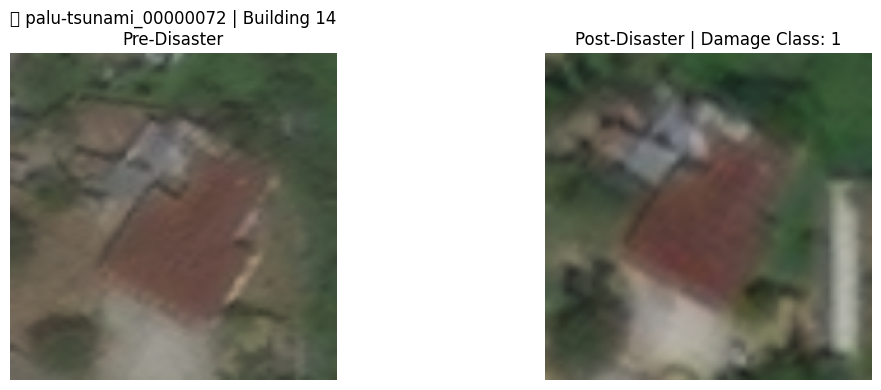

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import random

def plot_pre_post_samples(paths_dict, n_samples=3):
    """
    Randomly plots a few pre/post image pairs with their damage labels
    from the cropped dataset.
    """
    # Collect all (img_id, building_id, data) tuples
    all_buildings = [
        (img_id, b_id, data)
        for img_id, buildings in paths_dict.items()
        for b_id, data in buildings.items()
    ]

    # Shuffle for randomness
    random.shuffle(all_buildings)

    # Pick N samples
    samples = all_buildings[:n_samples]

    # Plot
    plt.figure(figsize=(12, n_samples * 4))

    for idx, (img_id, b_id, data) in enumerate(samples, 1):
        pre_path = data['pre_path']
        post_path = data['post_path']
        label = data['label']

        pre_img = Image.open(pre_path)
        post_img = Image.open(post_path)

        # Pre
        plt.subplot(n_samples, 2, (idx - 1) * 2 + 1)
        plt.imshow(pre_img)
        plt.axis("off")
        plt.title(f"🧱 {img_id} | Building {b_id}\nPre-Disaster")

        # Post
        plt.subplot(n_samples, 2, (idx - 1) * 2 + 2)
        plt.imshow(post_img)
        plt.axis("off")
        plt.title(f"Post-Disaster | Damage Class: {label}")

    plt.tight_layout()
    plt.show()
plot_pre_post_samples(data_paths, n_samples=1)

In [ ]:
import pandas as pd

def data_paths_to_df(data_paths):
    records = []

    for image_id, buildings in data_paths.items():
        for b_id, info in buildings.items():
            records.append({
                'image_id': image_id,
                'building_id': b_id,
                'label': info.get('label'),
                'pre_path': info.get('pre_path'),
                'post_path': info.get('post_path')
            })

    df = pd.DataFrame(records)
    return df

# Example usage
df = data_paths_to_df(data_paths)



# need to improve the qulity of the input images

In [ ]:
import cv2
import numpy as np

def sharpen_image(image):
    gaussian = cv2.GaussianBlur(image, (3, 3), 1.0)
    sharpened = cv2.addWeighted(image, 1.5, gaussian, -0.5, 0)
    return sharpened
def apply_clahe(image,clip=3.0):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    return cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)



In [ ]:
import cv2

# Read image from path first
pre_img  = cv2.imread(df['pre_path'][802])   # example for first image
post_img = cv2.imread(df['post_path'][802])

# Optional: convert to RGB (OpenCV reads as BGR)
pre_img  = cv2.cvtColor(pre_img, cv2.COLOR_BGR2RGB)
post_img = cv2.cvtColor(post_img, cv2.COLOR_BGR2RGB)

# Then apply enhancement
# cropped_pre  = apply_clahe(sharpen_image(pre_img))
# cropped_post = apply_clahe(sharpen_image(post_img))

cropped_pre  = apply_clahe(sharpen_image(pre_img), clip=3.0)
cropped_post = apply_clahe(sharpen_image(post_img), clip=3.0)

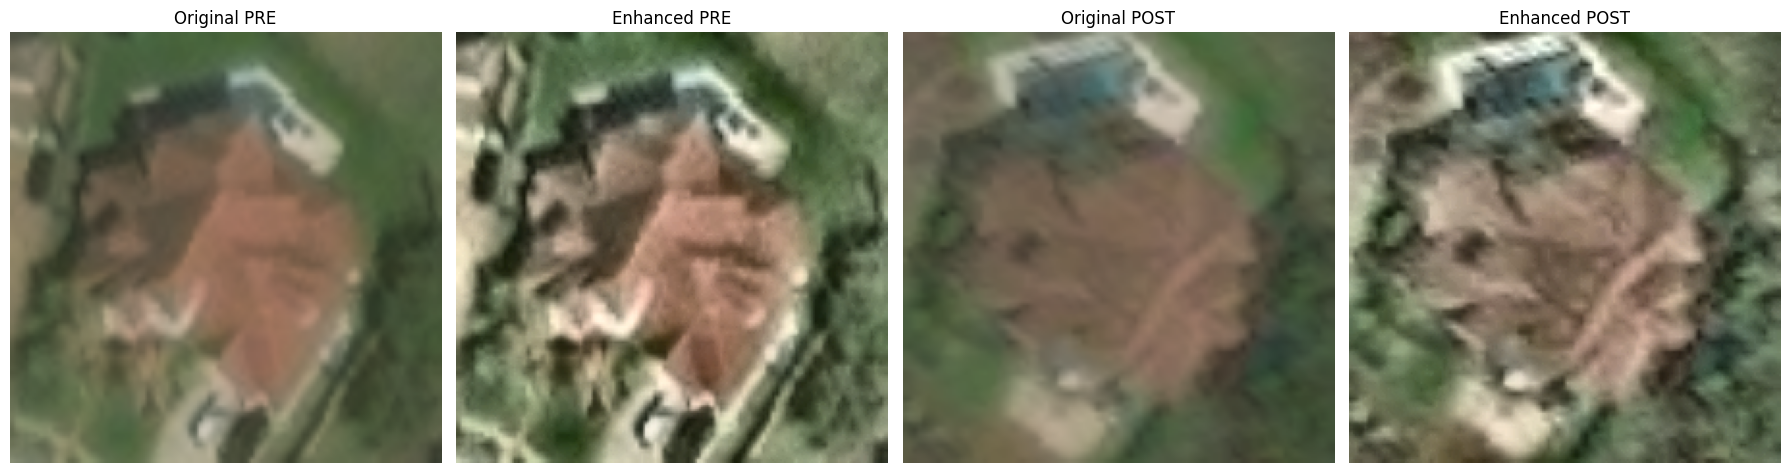

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4, figsize=(18, 5))

axes[0].imshow(pre_img)
axes[0].set_title('Original PRE')
axes[0].axis('off')

axes[1].imshow(cropped_pre)
axes[1].set_title('Enhanced PRE')
axes[1].axis('off')

axes[2].imshow(post_img)
axes[2].set_title('Original POST')
axes[2].axis('off')

axes[3].imshow(cropped_post)
axes[3].set_title('Enhanced POST')
axes[3].axis('off')

plt.tight_layout()
plt.show()


## pre processing

In [ ]:
import os
from tqdm import tqdm
import cv2

pre_images = []
post_images = []
labels = []

for img_id, buildings in tqdm(data_paths.items()):
    for b_id, data in buildings.items():
        pre_path  = data['pre_path']
        post_path = data['post_path']

        # Read and enhance
        pre_img  = cv2.imread(pre_path)
        post_img = cv2.imread(post_path)

        if pre_img is None or post_img is None:
            print(f"⚠️ Missing file for {img_id} | Building {b_id}, skipping.")
            continue  # skip missing files

        # Convert to RGB
        pre_img  = cv2.cvtColor(pre_img, cv2.COLOR_BGR2RGB)
        post_img = cv2.cvtColor(post_img, cv2.COLOR_BGR2RGB)

        # Apply enhancement
        pre_enh  = apply_clahe(sharpen_image(pre_img), clip=3.0)
        post_enh = apply_clahe(sharpen_image(post_img), clip=3.0)

        # Resize for ResNet
        # pre_enh  = cv2.resize(pre_enh, (224, 224))
        # post_enh = cv2.resize(post_enh, (224, 224))

        pre_images.append(pre_enh)
        post_images.append(post_enh)
        labels.append(data['label'])


100%|██████████| 88/88 [00:16<00:00,  5.37it/s]


array([[[ 70, 112,  73],
        [ 70, 112,  73],
        [ 77, 119,  80],
        ...,
        [124, 137,  96],
        [124, 137,  96],
        [124, 137,  96]],

       [[ 70, 112,  73],
        [ 69, 112,  74],
        [ 77, 119,  80],
        ...,
        [126, 140, 100],
        [124, 137,  96],
        [124, 137,  96]],

       [[ 73, 115,  76],
        [ 72, 112,  72],
        [ 78, 122,  83],
        ...,
        [120, 133,  92],
        [120, 133,  92],
        [120, 133,  92]],

       ...,

       [[ 65,  92,  62],
        [ 65,  92,  62],
        [ 67,  91,  64],
        ...,
        [166, 186, 150],
        [176, 196, 160],
        [174, 194, 158]],

       [[ 76, 101,  71],
        [ 71,  99,  69],
        [ 71,  98,  71],
        ...,
        [176, 196, 160],
        [181, 199, 164],
        [180, 198, 163]],

       [[ 71,  99,  69],
        [ 71,  99,  69],
        [ 76, 101,  73],
        ...,
        [178, 195, 161],
        [180, 198, 163],
        [180, 198, 163]]], dtype=uint8)
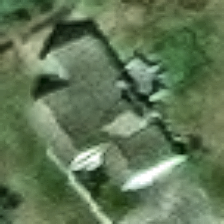

In [ ]:
pre_images[2]

array([[[ 21,  47,  10],
        [ 21,  47,  10],
        [ 23,  50,  11],
        ...,
        [ 46,  64,  45],
        [ 46,  64,  45],
        [ 46,  64,  45]],

       [[ 21,  47,  10],
        [ 21,  47,  10],
        [ 24,  50,  14],
        ...,
        [ 46,  64,  45],
        [ 46,  64,  45],
        [ 46,  64,  45]],

       [[ 18,  44,   6],
        [ 18,  44,   6],
        [ 21,  47,  10],
        ...,
        [ 49,  68,  47],
        [ 46,  64,  45],
        [ 46,  64,  45]],

       ...,

       [[ 79, 106,  72],
        [ 83, 110,  74],
        [ 75,  99,  63],
        ...,
        [ 44,  62,  40],
        [ 42,  59,  37],
        [ 42,  59,  37]],

       [[ 90, 117,  78],
        [ 90, 117,  81],
        [ 75,  99,  65],
        ...,
        [ 44,  62,  40],
        [ 42,  59,  37],
        [ 42,  59,  37]],

       [[ 90, 117,  81],
        [ 90, 117,  81],
        [ 75,  99,  65],
        ...,
        [ 44,  62,  38],
        [ 42,  59,  37],
        [ 42,  59,  37]]], dtype=uint8)
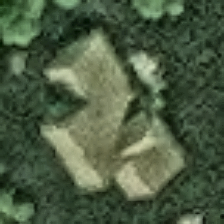

In [ ]:
post_images[2]

In [ ]:
pre_images = np.array(pre_images, dtype=np.float32)
post_images = np.array(post_images, dtype=np.float32)

In [ ]:
from sklearn.model_selection import train_test_split

train_pre, test_pre, train_post, test_post, train_y, test_y = train_test_split(
    pre_images, post_images, labels, test_size=0.2, random_state=42, stratify=labels
)

In [ ]:
train_pre.shape, test_pre.shape, train_post.shape, test_post.shape, len(train_y), len(test_y)

((689, 224, 224, 3),
 (173, 224, 224, 3),
 (689, 224, 224, 3),
 (173, 224, 224, 3),
 689,
 173)

In [ ]:
train_y = np.array(train_y) - 1
test_y = np.array(test_y) - 1

In [ ]:
# import tensorflow as tf

# class WeightedF1Metric(tf.keras.metrics.Metric):
#     def __init__(self, num_classes=4, name="weighted_f1", **kwargs):
#         super().__init__(name=name, **kwargs)
#         self.num_classes = num_classes
#         # Explicitly define dtype to avoid mismatch (default float32)
#         self.tp = self.add_weight(name="tp", shape=(num_classes,), initializer="zeros", dtype=tf.float32)
#         self.fp = self.add_weight(name="fp", shape=(num_classes,), initializer="zeros", dtype=tf.float32)
#         self.fn = self.add_weight(name="fn", shape=(num_classes,), initializer="zeros", dtype=tf.float32)

#     def update_state(self, y_true, y_pred, sample_weight=None):
#         # Flatten and cast
#         y_true = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
#         y_pred = tf.argmax(y_pred, axis=-1)
#         y_pred = tf.cast(tf.reshape(y_pred, [-1]), tf.int32)

#         # Confusion matrix (vectorized)
#         cm = tf.math.confusion_matrix(
#             y_true, y_pred, num_classes=self.num_classes, dtype=tf.float32
#         )

#         # Compute TP, FP, FN per class
#         tp = tf.linalg.diag_part(cm)
#         fp = tf.reduce_sum(cm, axis=0) - tp
#         fn = tf.reduce_sum(cm, axis=1) - tp

#         # Safe updates to metric state
#         self.tp.assign_add(tp)
#         self.fp.assign_add(fp)
#         self.fn.assign_add(fn)

#     def result(self):
#         precision = self.tp / (self.tp + self.fp + 1e-8)
#         recall = self.tp / (self.tp + self.fn + 1e-8)
#         f1 = 2 * precision * recall / (precision + recall + 1e-8)

#         # Weighted average
#         weights = self.tp + self.fn
#         weighted_f1 = tf.reduce_sum(f1 * (weights / (tf.reduce_sum(weights) + 1e-8)))
#         return weighted_f1

#     def reset_state(self):
#         for v in self.variables:
#             v.assign(tf.zeros_like(v))



import tensorflow as tf

@tf.keras.utils.register_keras_serializable()
class SparseCategoricalFocalLoss(tf.keras.losses.Loss):
    def __init__(self, gamma=2.0, class_weights=None, label_smoothing=0.05,
                 reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE,
                 name="sparse_categorical_focal_loss", **kwargs):
        super().__init__(reduction=reduction, name=name, **kwargs)
        self.gamma = gamma
        self.label_smoothing = label_smoothing
        self.class_weights = tf.constant(class_weights, dtype=tf.float32) if class_weights is not None else None

    def call(self, y_true, y_pred):
        """
        y_true: (batch,) integer class labels
        y_pred: (batch, num_classes) softmax probabilities
        """
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.clip_by_value(y_pred, 1e-8, 1.0 - 1e-8)

        num_classes = tf.shape(y_pred)[-1]
        y_true_one_hot = tf.one_hot(y_true, depth=num_classes, dtype=tf.float32)

        # --- Apply label smoothing ---
        if self.label_smoothing > 0:
            smooth_positives = 1.0 - self.label_smoothing
            smooth_negatives = self.label_smoothing / tf.cast(num_classes - 1, tf.float32)
            y_true_one_hot = y_true_one_hot * smooth_positives + smooth_negatives

        # --- Compute focal loss ---
        pt = tf.reduce_sum(y_true_one_hot * y_pred, axis=-1)
        focal_factor = tf.pow(1.0 - pt, self.gamma)
        ce_loss = -tf.reduce_sum(y_true_one_hot * tf.math.log(y_pred), axis=-1)
        loss = focal_factor * ce_loss

        # --- Apply class weights (optional) ---
        if self.class_weights is not None:
            weights = tf.gather(self.class_weights, y_true)
            loss = loss * weights

        return tf.reduce_mean(loss)

    def get_config(self):
        config = super().get_config()
        config.update({
            "gamma": self.gamma,
            "label_smoothing": self.label_smoothing,
            "class_weights": self.class_weights.numpy().tolist() if self.class_weights is not None else None,
        })
        return config
#class_weights = [0.28, 4.27, 2.20, 1.67]
class_weights = [0.2, 2.5, 1.6, 1.2]

In [ ]:
import tensorflow as tf
import numpy as np

# ---------------- Multi-class Precision ---------------- #
class MultiClassPrecision(tf.keras.metrics.Metric):
    def __init__(self, num_classes=4, name="precision", **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.tp = self.add_weight(shape=(num_classes,), initializer="zeros", dtype=tf.float32)
        self.fp = self.add_weight(shape=(num_classes,), initializer="zeros", dtype=tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
        y_pred = tf.cast(tf.argmax(y_pred, axis=-1), tf.int32)

        cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=self.num_classes, dtype=tf.float32)
        tp = tf.linalg.diag_part(cm)
        fp = tf.reduce_sum(cm, axis=0) - tp

        self.tp.assign_add(tp)
        self.fp.assign_add(fp)

    def result(self):
        precision = self.tp / (self.tp + self.fp + 1e-8)
        return precision  # <-- return per-class precision

    def reset_state(self):
        for v in self.variables:
            v.assign(tf.zeros_like(v))


# ---------------- Multi-class Recall ---------------- #
class MultiClassRecall(tf.keras.metrics.Metric):
    def __init__(self, num_classes=4, name="recall", **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.tp = self.add_weight(shape=(num_classes,), initializer="zeros", dtype=tf.float32)
        self.fn = self.add_weight(shape=(num_classes,), initializer="zeros", dtype=tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
        y_pred = tf.cast(tf.argmax(y_pred, axis=-1), tf.int32)

        cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=self.num_classes, dtype=tf.float32)
        tp = tf.linalg.diag_part(cm)
        fn = tf.reduce_sum(cm, axis=1) - tp

        self.tp.assign_add(tp)
        self.fn.assign_add(fn)

    def result(self):
        recall = self.tp / (self.tp + self.fn + 1e-8)
        return recall  # <-- return per-class recall

    def reset_state(self):
        for v in self.variables:
            v.assign(tf.zeros_like(v))


# ---------------- Per-Class Harmonic Mean ---------------- #
import tensorflow as tf

@tf.keras.utils.register_keras_serializable()
class PerClassHarmonicMean(tf.keras.metrics.Metric):
    def __init__(self, num_classes=4, name="harmonic_mean", **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.eps = 1e-8

        # Store confusion components
        self.tp = self.add_weight(shape=(num_classes,), initializer="zeros", dtype=tf.float32)
        self.fp = self.add_weight(shape=(num_classes,), initializer="zeros", dtype=tf.float32)
        self.fn = self.add_weight(shape=(num_classes,), initializer="zeros", dtype=tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Flatten
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
        y_pred = tf.cast(tf.argmax(y_pred, axis=-1), tf.int32)
        y_pred = tf.reshape(y_pred, [-1])

        # Compute confusion matrix
        cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=self.num_classes, dtype=tf.float32)
        tp = tf.linalg.diag_part(cm)
        fp = tf.reduce_sum(cm, axis=0) - tp
        fn = tf.reduce_sum(cm, axis=1) - tp

        # Accumulate totals
        self.tp.assign_add(tp)
        self.fp.assign_add(fp)
        self.fn.assign_add(fn)

    def result(self):
        precision = self.tp / (self.tp + self.fp + self.eps)
        recall = self.tp / (self.tp + self.fn + self.eps)
        harmonic = 2.0 / ((1.0 / (precision + self.eps)) + (1.0 / (recall + self.eps)))

        # Return macro-average harmonic mean (mean of all classes)
        return tf.reduce_mean(harmonic)

    def reset_state(self):
        for v in self.variables:
            v.assign(tf.zeros_like(v))



# ---------------- Per-Class Metrics Callback ---------------- #
class PerClassMetrics(tf.keras.callbacks.Callback):
    def __init__(self, x_val, y_val, num_classes=4):
        super().__init__()
        self.x_val = x_val
        self.y_val = y_val
        self.num_classes = num_classes

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.x_val, verbose=0)
        y_pred = np.argmax(y_pred, axis=1)
        y_true = np.array(self.y_val).reshape(-1)

        cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=self.num_classes).numpy()
        tp = np.diag(cm)
        fp = np.sum(cm, axis=0) - tp
        fn = np.sum(cm, axis=1) - tp

        precision = tp / (tp + fp + 1e-8)
        recall = tp / (tp + fn + 1e-8)
        harmonic = 2.0 / ((1.0 / (precision + 1e-8)) + (1.0 / (recall + 1e-8)))

        print(f"\nEpoch {epoch+1} — Per-class metrics:")
        for i in range(self.num_classes):
            print(f"  Class {i}: Precision = {precision[i]:.3f}, Recall = {recall[i]:.3f}, Harmonic Mean = {harmonic[i]:.3f}")
        print("-" * 60)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models,regularizers
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

# --- Config ---
INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = 4



def make_backbone(name, trainable=False):
    inp = layers.Input(shape=INPUT_SHAPE, name=f"{name}_input")
    x = layers.Lambda(preprocess_input)(inp)
    base = ResNet50(include_top=False, weights='imagenet', input_tensor=x)
    x = layers.GlobalAveragePooling2D()(base.output)
    model = models.Model(inp, x, name=f"{name}_backbone")
    model.trainable = trainable
    return model

# --- Backbone for pre- and post-disaster images ---
pre_b = make_backbone('pre', trainable=False)
post_b = make_backbone('post', trainable=False)

# --- Input layers ---
pre_in  = layers.Input(shape=INPUT_SHAPE, name='pre_image')
post_in = layers.Input(shape=INPUT_SHAPE, name='post_image')

# --- Feature extraction ---
pre_feat  = pre_b(pre_in)
post_feat = post_b(post_in)

# # --- Combine features (no diff now) ---
x = layers.Concatenate()([pre_feat, post_feat])
# x = layers.BatchNormalization()(x)
# x = layers.Dense(512, activation='relu')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.4)(x)
# x = layers.Dense(256, activation='relu')(x)
# x = layers.Dropout(0.3)(x)

# # --- Classification head ---
# out = layers.Dense(NUM_CLASSES, activation='softmax')(x)




x = layers.Dense(512, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(256, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

out = layers.Dense(NUM_CLASSES, activation='softmax',
                   kernel_regularizer=regularizers.l2(1e-4))(x)


# --- Final model ---
model = models.Model([pre_in, post_in], out)


model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ pre_image           │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ post_image          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pre_backbone        │ (None, 2048)      │ 23,587,712 │ pre_image[0][0]   │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ post_backbone       │ (None, 2048)      │ 23,587,712 │ post_image[0][0]  │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 4096)      │          0 │ pre_backbone[0][… │
│ (Concatenate)       │                   │            │ post_backbone[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  2,097,664 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 4)         │      1,028 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 49,408,516 (188.48 MB)

 Trainable params: 2,231,556 (8.51 MB)

 Non-trainable params: 47,176,960 (179.97 MB)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- Data augmentation for generalization ---
augmenter = ImageDataGenerator(
    rotation_range=15,         # small random rotations
    width_shift_range=0.1,     # horizontal translations
    height_shift_range=0.1,    # vertical translations
    zoom_range=0.15,           # random zoom-in/out
    horizontal_flip=True,      # flip to simulate viewpoint changes
    brightness_range=[0.8, 1.2],
    fill_mode='reflect'        # fill gaps naturally
)

# Apply augmentation to BOTH pre and post images
def augment_batch(pre_imgs, post_imgs, labels):
    aug_pre, aug_post = [], []
    for pre, post in zip(pre_imgs, post_imgs):
        # Ensure consistent random transform for pre & post
        seed = np.random.randint(0, 10000)
        pre_aug = augmenter.random_transform(pre, seed=seed)
        post_aug = augmenter.random_transform(post, seed=seed)
        aug_pre.append(pre_aug)
        aug_post.append(post_aug)
    return np.array(aug_pre), np.array(aug_post), np.array(labels)


In [ ]:
# --- Phase 1: Train only the classifier head (freeze all ResNet layers) ---

# Step 1: Freeze all backbone layers
for layer in model.get_layer('pre_backbone').layers:
    layer.trainable = False
for layer in model.get_layer('post_backbone').layers:
    layer.trainable = False

# Step 2: Compile and train head
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=SparseCategoricalFocalLoss(gamma=2.0, class_weights=class_weights,label_smoothing=0.02),
    metrics=[
        'accuracy',
        MultiClassPrecision(num_classes=4),
        MultiClassRecall(num_classes=4),
        PerClassHarmonicMean(num_classes=4)
    ]
)


aug_pre, aug_post, aug_y = augment_batch(train_pre, train_post, train_y)

history_1 = model.fit(
    [aug_pre, aug_post],
    np.array(aug_y),
    validation_data=([test_pre, test_post], np.array(test_y)),
    epochs=10,
    batch_size=16,
    verbose=1,
    callbacks=[PerClassMetrics([test_pre, test_post], test_y, num_classes=4)]
)


# --- Phase 2: Gradual Unfreezing + Freeze BatchNorm ---

# Function to unfreeze progressively deeper layers
# def unfreeze_backbone_layers(model, num_layers):
#     for name in ['pre_backbone', 'post_backbone']:
#         backbone = model.get_layer(name)
#         for layer in backbone.layers[-num_layers:]:
#             # Keep BatchNorm frozen for stability
#             if isinstance(layer, tf.keras.layers.BatchNormalization):
#                 layer.trainable = False
#             else:
#                 layer.trainable = True


# # Step 3: Gradually unfreeze and fine-tune
# unfreeze_schedule = [10, 20, 40]  # progressively unfreeze more layers

# for i, num_layers in enumerate(unfreeze_schedule):
#     print(f"\n Phase 2.{i+1}: Unfreezing last {num_layers} layers of each backbone")

#     unfreeze_backbone_layers(model, num_layers)

#     # Smaller LR for backbone, larger for head
#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
#         loss=SparseCategoricalFocalLoss(gamma=1.5, class_weights=class_weights,label_smoothing=0.05),
#         metrics=[
#             'accuracy',
#             MultiClassPrecision(num_classes=4),
#             MultiClassRecall(num_classes=4),
#             PerClassHarmonicMean(num_classes=4)
#         ]
#     )

#     aug_pre, aug_post, aug_y = augment_batch(train_pre, train_post, train_y)

#     history_2 = model.fit(
#         [aug_pre, aug_post],
#         np.array(aug_y),
#         validation_data=([test_pre, test_post], np.array(test_y)),
#         epochs=5,  # shorter per stage
#         batch_size=16,
#         verbose=1,
#         callbacks=[PerClassMetrics([test_pre, test_post], test_y, num_classes=4)]
#     )



# --- Phase 2: Gradual Unfreezing + Freeze BatchNorm ---

def unfreeze_backbone_layers(model, num_layers):
    for name in ['pre_backbone', 'post_backbone']:
        backbone = model.get_layer(name)
        for layer in backbone.layers[-num_layers:]:
            if isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.trainable = False  # keep BN frozen for stability
            else:
                layer.trainable = True


# --- Gradual schedule: (num_layers, epochs, learning_rate) ---
unfreeze_schedule = [
    (10, 4, 2e-5),   # fine-tune top 10 layers first
    (20, 10, 1e-5),   # then deeper
    (40, 15, 5e-6)   # finally, full adaptation
]

for i, (num_layers, n_epochs, lr) in enumerate(unfreeze_schedule):
    print(f"\n Phase 2.{i+1}: Unfreezing last {num_layers} layers — training {n_epochs} epochs @ LR={lr}")

    unfreeze_backbone_layers(model, num_layers)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=SparseCategoricalFocalLoss(gamma=2.0, class_weights=class_weights, label_smoothing=0.05),
        metrics=[
            'accuracy',
            MultiClassPrecision(num_classes=4),
            MultiClassRecall(num_classes=4),
            PerClassHarmonicMean(num_classes=4)
        ]
    )

    # Apply data augmentation per phase for better generalization
    aug_pre, aug_post, aug_y = augment_batch(train_pre, train_post, train_y)

    history = model.fit(
        [aug_pre, aug_post],
        np.array(aug_y),
        validation_data=([test_pre, test_post], np.array(test_y)),
        epochs=n_epochs,
        batch_size=16,
        verbose=1,
        callbacks=[PerClassMetrics([test_pre, test_post], test_y, num_classes=4)]
    )



Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.2464 - harmonic_mean: 0.2063 - loss: 1.4666 - precision: 0.2472 - recall: 0.2454
Epoch 1 — Per-class metrics:
  Class 0: Precision = 0.750, Recall = 0.868, Harmonic Mean = 0.805
  Class 1: Precision = 0.200, Recall = 0.154, Harmonic Mean = 0.174
  Class 2: Precision = 0.400, Recall = 0.200, Harmonic Mean = 0.267
  Class 3: Precision = 0.762, Recall = 0.615, Harmonic Mean = 0.681
------------------------------------------------------------
44/44 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.2470 - harmonic_mean: 0.2069 - loss: 1.4638 - precision: 0.2479 - recall: 0.2462 - val_accuracy: 0.6994 - val_harmonic_mean: 0.4816 - val_loss: 0.7197 - val_precision: 0.5280 - val_recall: 0.4594
Epoch 2/10
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.4141 - harmonic_mean: 0.3792 - loss: 0.9362 - precision: 0.3997 - recall: 0.4736
Epoch 2 — Per-class metrics:
  Class 0: Precision = 0.814, Recall = 0.728, Harmonic Mean = 0.76

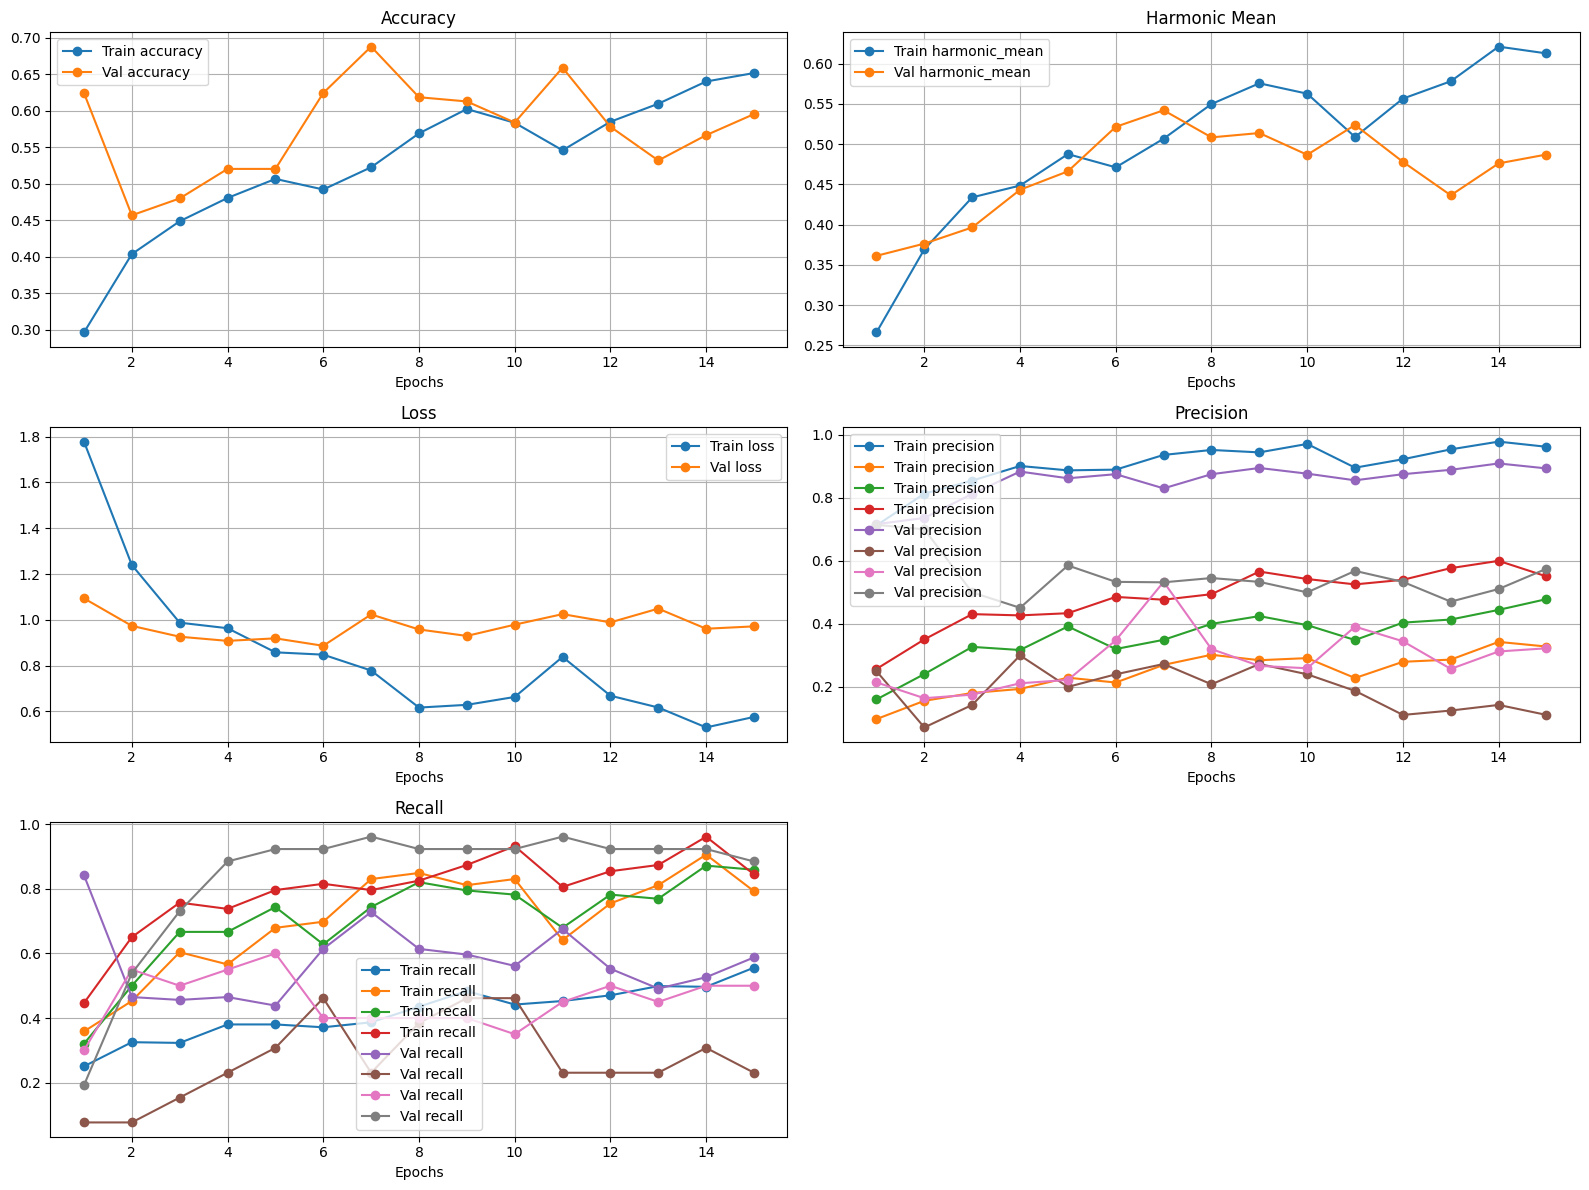

In [ ]:
import matplotlib.pyplot as plt

# Combine history_1 and history_2
def combine_histories(h1, h2):
    combined = {}
    for key in h1.history.keys():
        combined[key] = h1.history[key] + h2.history.get(key, [])
    return combined

# Merge both histories
full_history = combine_histories(history_1, history_2)

# Extract keys dynamically
metric_names = [m for m in full_history.keys() if not m.startswith('val_')]
val_metric_names = [m for m in full_history.keys() if m.startswith('val_')]

# Determine number of epochs
epochs = range(1, len(full_history[metric_names[0]]) + 1)

# Plot all metrics
plt.figure(figsize=(16, 12))

for i, metric in enumerate(metric_names):
    plt.subplot(3, 2, i + 1)
    plt.plot(epochs, full_history[metric], '-o', label=f"Train {metric}")

    val_key = f"val_{metric}"
    if val_key in full_history:
        plt.plot(epochs, full_history[val_key], '-o', label=f"Val {metric}")

    plt.title(metric.replace("_", " ").title())
    plt.xlabel("Epochs")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


### tommorrow

In [ ]:
# first reduce the dense nodes 512->256-> 0.3 & 1024->512->0.4 (done )-> improved one with dropout 0.5 and l2
# then gamma values from 2 to 1.5 (done)
# data aumenations
# class wighs agujust & normalize (done)
# add regularization(done)
# for the phase 2 use gradually unfreezing and descreminate lr also reseach about the bactnormalization (done)
# label smoothing(done )
